# KNN

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn import neighbors, tree, naive_bayes
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [2]:
X_train_s = np.load('data/X_train_s.npy')
X_test_s = np.load('data/X_test_s.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

### Optimizing the parameters

In [3]:
def calc_params(X, y, clf, param_values, param_name, K, verbose=False):
    
    # Convert input to Numpy arrays
    X = np.array(X)
    y = np.array(y)

    # initialize training and testing score arrays with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):

        # set classifier parameters
        clf.set_params(**{param_name:param_value})
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_splits=K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        j = 0
        
        for train, test in cv.split(X):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit(X[train], y[train])
            k_train_scores[j] = clf.score(X[train], y[train])
            k_test_scores[j] = clf.score(X[test], y[test])
            j += 1
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
        
        if (verbose):
            s = "{} {:.3f} train {:.3f} test {:.3f}"
            print(s.format(param_name, param_value, train_scores[i], test_scores[i]))
       
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")
    plt.grid(True)

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

n_neighbors 1.000 train 1.000 test 0.916
n_neighbors 2.000 train 0.949 test 0.912
n_neighbors 3.000 train 0.958 test 0.925
n_neighbors 4.000 train 0.943 test 0.921
n_neighbors 5.000 train 0.948 test 0.927
n_neighbors 6.000 train 0.939 test 0.923
n_neighbors 7.000 train 0.943 test 0.927
n_neighbors 8.000 train 0.937 test 0.924
n_neighbors 9.000 train 0.939 test 0.927
n_neighbors 10.000 train 0.935 test 0.924
n_neighbors 11.000 train 0.937 test 0.926
n_neighbors 12.000 train 0.933 test 0.924
n_neighbors 13.000 train 0.935 test 0.926
n_neighbors 14.000 train 0.932 test 0.924
n_neighbors 15.000 train 0.933 test 0.926
n_neighbors 16.000 train 0.931 test 0.924
n_neighbors 17.000 train 0.932 test 0.925
n_neighbors 18.000 train 0.930 test 0.923
n_neighbors 19.000 train 0.930 test 0.925
n_neighbors 20.000 train 0.929 test 0.923


NameError: name 'param_range' is not defined

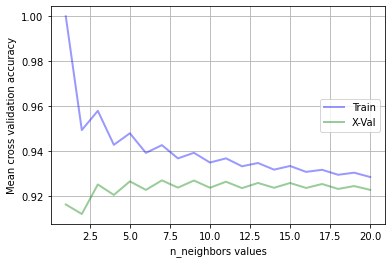

In [6]:
knn = neighbors.KNeighborsClassifier(n_jobs=-1)
param_range = range(1,21)

train_scores, test_scores = calc_params(X_train_s, y_train, knn, k, 'n_neighbors', 3, True)

max_at = np.where(test_scores==np.max(test_scores))[0][0]
print("\nBest Score {:.3f} for parameter value".format(test_scores[max_at]), [*param_range][max_at])

### Gridsearch

In [5]:
knn = neighbors.KNeighborsClassifier()

# parameter values to be optimized for
parameters = {
    'n_neighbors' : [*range(3, 8)],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm' : ['brute']
}

# GridSearch finds the best combination of paramters
knn_gs = GridSearchCV(knn, parameters, verbose=3, cv=3, scoring='accuracy', n_jobs=-1, return_train_score=False)

In [6]:
knn_gs.fit(X_train_s, y_train) # performs gridsearch

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 31.0min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['brute'], 'n_neighbors': [3, 4, 5, 6, 7],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [7]:
print(knn_gs.best_params_)
print("RMSE (test): {:.4f}".format(knn_gs.best_score_))

{'algorithm': 'brute', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
RMSE (test): 0.9358


### Perfomance evaluation

In [12]:
knn = neighbors.KNeighborsClassifier(n_neighbors=6, 
                             p=1, 
                             weights='distance',
                             n_jobs=-1)

fit = knn.fit(X_train_s, y_train)
predicted = fit.predict(X_test_s)
train_eval_score = knn.score(X_train_s, y_train)
test_eval_score = knn.score(X_test_s, y_test)

print("Evaluation scores Train {:.3f} Test {:.3f}".format(train_eval_score, test_eval_score))

Evaluation scores Train 1.000 Test 0.938


In [16]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

In [18]:
def fit_predict_score(y_test, predicted):
    """Predicts the average accuracy score of a classifier clf and outputs a confusion matrix."""
    
    #cross tabulation of predicted and actual values produces the correlation matrix
    confusion_matrix =  pd.crosstab(index=np.ravel(y_test), columns=predicted.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(y_test , predicted),4)
    plt.title("Confusion Matrix", fontsize = 12)
    plt.show()
    print("Accuracy Score: ",accuracy)
    print (metrics.classification_report(y_test,predicted))

In [17]:
measure_performance(X_train_s, y_test, knn)

Accuracy:1.000 

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58550
           1       1.00      1.00      1.00     45039

    accuracy                           1.00    103589
   macro avg       1.00      1.00      1.00    103589
weighted avg       1.00      1.00      1.00    103589
 

Confussion matrix
[[58550     0]
 [    0 45039]] 



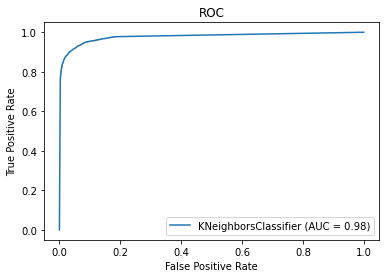

In [13]:
rf_roc = plot_roc_curve(knn, X_test_s, y_test)
plt.title("ROC")
plt.show()

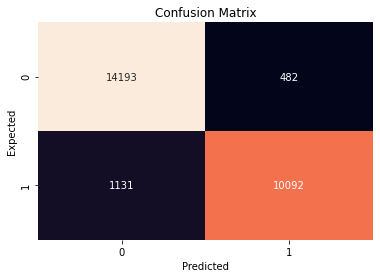

Accuracy Score:  0.9377
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14675
           1       0.95      0.90      0.93     11223

    accuracy                           0.94     25898
   macro avg       0.94      0.93      0.94     25898
weighted avg       0.94      0.94      0.94     25898



In [19]:
fit_predict_score(y_test, predicted);